# Assignment 02: Supervised Learning

This assignment explores **supervised learning** through the lens of two classification algorithms: **Support Vector Machines (SVM)** and **Multi-Layer Perceptrons (MLP)**. You will apply both models to datasets that highlight their strengths and limitations, use grid search with cross-validation to find optimal hyperparameters, and report results using standard classification metrics.

### Hand-in Instructions

Name your files using the pattern `{group_number}_assignment_02` (e.g., `g03_assignment_02.ipynb`).

Submit the following two files:

1. **`.ipynb`** — The completed notebook with all outputs saved
2. **`.pdf`** — Exported PDF version (see [README: Exporting Notebooks to HTML and PDF](../../README.md#exporting-notebooks-to-html-and-pdf))

Both files must be fully self-contained and ready to read without running any cells.

### Overview

| Task  | Topic                           | Points  |
| ----- | ------------------------------- | ------- |
| **1** | **Dry Bean Exploration**        |         |
| 1.1   | Class balance                   | 5       |
| 1.2   | Feature scales                  | 5       |
| 1.3   | Feature distributions           | 5       |
| **2** | **Dry Bean Classification**     |         |
| 2.1   | SVM grid search                 | 0       |
| 2.2   | SVM evaluation                  | 5       |
| 2.3   | MLP grid search                 | 15      |
| 2.4   | MLP evaluation                  | 15      |
| 2.5   | Compare SVM vs MLP              | 10      |
| **3** | **Checkerboard Classification** |         |
| 3.1   | Visualize Checkerboard          | 5       |
| 3.2   | SVM classification              | 10      |
| 3.3   | MLP classification              | 10      |
| 3.4   | Compare decision boundaries     | 15      |
|       | **Total**                       | **100** |


---

## Setup


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

from assignment_utils import (
    generate_checkerboard,
    load_dry_bean,
    plot_decision_boundary,
    plot_grid_search_heatmap,
    plot_roc_curves,
    print_evaluation_metrics,
    print_grid_search_results,
)

# Set random seed for reproducibility
np.random.seed(42)

## Task 1: Setup & Data Exploration

In this section, you will load and explore the **Dry Bean Dataset**, a real-world multi-class classification problem from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset). Images of 7 types of dry beans were captured, and 16 geometric features were extracted. Run the cell below to load the data.

#### Feature Descriptions

The 16 features are derived from image segmentation and morphological analysis (Köklü & Özkan, 2020). Let $A$ = Area, $P$ = Perimeter, $L$ = MajorAxisLength, $l$ = MinorAxisLength, $C$ = ConvexArea, and $E_d$ = EquivDiameter.

| Feature             | Description                                               | Formula/Definition       |
| ------------------- | --------------------------------------------------------- | ------------------------ |
| **Area**            | Number of pixels within the bean boundary                 | $A$ (pixels)             |
| **Perimeter**       | Length of the bean's border                               | $P$ (pixels)             |
| **MajorAxisLength** | Length of the longest line through the bean               | $L$                      |
| **MinorAxisLength** | Longest line perpendicular to the major axis              | $l$                      |
| **AspectRatio**\*   | Ratio of major to minor axis                              | $K = L / l$              |
| **Eccentricity**    | Eccentricity of an ellipse with same moments              | $\sqrt{1 - (l/L)^2}$     |
| **ConvexArea**      | Pixels in the smallest convex polygon containing the bean | $C$ (pixels)             |
| **EquivDiameter**   | Diameter of a circle with the same area                   | $E_d = \sqrt{4A/\pi}$    |
| **Extent**          | Ratio of bean area to bounding box area                   | $A / (\text{bbox area})$ |
| **Solidity**        | Ratio of bean area to convex hull area (convexity)        | $A / C$                  |
| **Roundness**       | Circularity measure                                       | $4\pi A / P^2$           |
| **Compactness**     | Roundness measure using equivalent diameter               | $E_d / L$                |
| **ShapeFactor1**    | Length-to-area ratio                                      | $L / A$                  |
| **ShapeFactor2**    | Width-to-area ratio                                       | $l / A$                  |
| **ShapeFactor3**    | Ratio of area to circle with diameter $L$                 | $4A / (\pi L^2)$         |
| **ShapeFactor4**    | Ratio of area to ellipse with axes $L$, $l$               | $4A / (\pi L l)$         |

\*Note: This feature is misspelled as "AspectRation" in the original dataset.

**Target:** 7 bean classes — Seker, Barbunya, Bombay, Cali, Dermason, Horoz, Sira


In [ ]:
# Load Dry Bean dataset
X_bean, y_bean, feature_names_bean, class_names_bean = load_dry_bean()

# Create DataFrame
df_bean = pd.DataFrame(X_bean, columns=feature_names_bean)
df_bean["Class"] = [class_names_bean[i] for i in y_bean]

print(f"Shape: {df_bean.shape}")
print(f"Classes: {class_names_bean}")
df_bean.head()

In [ ]:
df_bean["Class"].value_counts()

### Task 1.1 Class Balance

- Task: Visualize the distribution of bean classes and analyze class imbalance.
- Points: 5
- Expectations: Bar chart showing class counts. 2-3 sentences discussing: (1) whether the dataset is balanced or imbalanced, (2) the ratio between the largest and smallest classes, and (3) potential implications for classifier training and evaluation.


In [ ]:
# Hint: Use sns.countplot()
# Bar chart of features for the first 4 entries

data = df_bean["Class"].value_counts()

ax = data.plot(kind="bar", figsize=(14, 6))
ax.set_title("Class Counts")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

#### Answer

Datasettet er ikke balansert. Den største klassen (DERMASON) har 3546 eksempler, mens den minste klassen (BOMBAY) har 522 eksempler, noe som gir et forhold på 6.8 mellom den største og minste klassen. Denne ubalansen kan føre til at klassifiseringsmodeller favoriserer de større klassene under trening, noe som kan resultere i dårligere ytelse på de mindre representerte klassene.

Datasettet er ikke balansert. Den største klassen (DERMASON) har 3546 eksempler, mens den minste klassen (BOMBAY) har 522 eksempler, noe som gir et forhold på 6.8 mellom den største og minste klassen. Denne ubalansen kan føre til at klassifiseringsmodeller favoriserer de større klassene under trening, noe som kan resultere i dårligere ytelse på de mindre representerte klassene.


### Task 1.2 Feature Scales

- Task: Analyze the range of values across all 16 features to determine if scaling is needed.
- Points: 5
- Expectations: Visualization comparing feature ranges. 1-2 sentences on whether scaling is required and why.
- Hint: Use `plt.yscale("log")` to show features with very different magnitudes on the same plot.


In [ ]:
# Compute max-min range for each feature
feature_ranges = df_bean[feature_names_bean].max() - df_bean[feature_names_bean].min()
feature_ranges = feature_ranges.sort_values(ascending=False)

# Plot the ranges per feature with sns.barplot()
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_ranges.index, y=feature_ranges.values, color="steelblue")

# Use plt.yscale("log") for better visualization of scale differences
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Range (max - min)")
plt.title("Feature Value Ranges (log scale)")
plt.tight_layout()
plt.show()

### Answer

Scaling er påkrevd for dette datasettet. De 16 funksjonene har svært forskjellige skalaer, med noen funksjoner som har verdier i tusenvis (f.eks. Area) og andre som har verdier nær null (f.eks. AspectRatio). Uten skalering kan modeller som SVM og MLP bli dominert av funksjoner med større skala. Derfor bør funksjonene normaliseres eller standardiseres før modelltrening.

Scaling er påkrevd for dette datasettet. De 16 funksjonene har svært forskjellige skalaer, med noen funksjoner som har verdier i tusenvis (f.eks. Area) og andre som har verdier nær null (f.eks. AspectRatio). Uten skalering kan modeller som SVM og MLP bli dominert av funksjoner med større skala. Derfor bør funksjonene normaliseres eller standardiseres før modelltrening.


### Task 1.3 Feature Distributions by Class

- Task: Explore how feature values differ across bean classes.
- Points: 5
- Expectations: Create overlapping histograms (or density plots) for all 16 features, colored by class (already done). Identify two features that, when combined, would provide good class separation and briefly justify your selection (2-3 sentences).


In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for ax, feat in zip(axes, feature_names_bean):
    sns.histplot(
        data=df_bean,
        x=feat,
        hue="Class",
        stat="density",
        common_norm=False,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_title(feat)
    ax.set_xlabel("Feature Value")
    ax.set_ylabel("Density")

# Add shared legend
handles, labels = [], []
for bean_class in sorted(df_bean["Class"].unique()):
    handles.append(
        plt.Line2D(
            [0],
            [0],
            color=sns.color_palette()[
                sorted(df_bean["Class"].unique()).index(bean_class)
            ],
            lw=4,
        )
    )
    labels.append(bean_class)
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5), fontsize=10)

plt.suptitle("Dry Bean Feature Distributions by Class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#### Answer

Av figurene over ser vi at det er ganske mye overlapp på alle, men at det på AspectRation er et ganske godt skille blå, rød og lilla. Da må vi ha en feature som har ganske god skille i oransj, grønn, brun og rosa. Vi ser at Perimeter har det. Derfor velger vi AspectRatio og Perimeter som de to funksjonene som gir best klasse-separasjon når de kombineres.

Av figurene over ser vi at det er ganske mye overlapp på alle, men at det på AspectRation er et ganske godt skille blå, rød og lilla. Da må vi ha en feature som har ganske god skille i oransj, grønn, brun og rosa. Vi ser at Perimeter har det. Derfor velger vi AspectRatio og Perimeter som de to funksjonene som gir best klasse-separasjon når de kombineres.


---

## Task 2: Dry Bean Classification

Now you will apply both SVM and MLP to the Dry Bean dataset. Since this is a multi-class problem with 7 classes, both algorithms should be able to achieve good performance with proper hyperparameter tuning.

First, let's prepare the data by splitting into train and test sets.


In [ ]:
# Cross-validation folds used for all grid searches
CV_FOLDS = 5

# Train/test split for Dry Bean (80/20)
X_bean_train, X_bean_test, y_bean_train, y_bean_test = train_test_split(
    X_bean, y_bean, test_size=0.2, random_state=42, stratify=y_bean
)

print(f"Training set: {len(X_bean_train)} samples")
print(f"Test set: {len(X_bean_test)} samples")

### Task 2.1 SVM Grid Search (Dry Bean)

**Note:** This is already answered for you so that you see how we can do grid search.

- Task: Use GridSearchCV to find optimal hyperparameters for an SVM classifier on the Dry Bean dataset. Use a Pipeline with StandardScaler and SVC (RBF kernel). Search over at least: `C` (3+ values) and `gamma` (3+ values).
- Points: 0
- Expectations: Working grid search code. Report best parameters and best CV score using `print_grid_search_results()`. Include a heatmap of CV scores for C vs gamma using `plot_grid_search_heatmap()`.


In [ ]:
# SVM Pipeline: StandardScaler + SVC (RBF kernel)
svm_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svc", SVC(random_state=42, kernel="rbf", probability=True)),
    ]
)

# Hyperparameter grid
svm_param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [0.001, 0.01, 0.1, 1],
}

# Grid search with cross-validation
svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid, cv=CV_FOLDS, scoring="accuracy", n_jobs=-1, refit=True
)
svm_grid.fit(X_bean_train, y_bean_train)

print_grid_search_results(svm_grid, "SVM (Dry Bean)")

# Heatmap of CV scores: C vs gamma
plot_grid_search_heatmap(
    svm_grid,
    param_x="svc__C",
    param_y="svc__gamma",
    title="SVM CV Accuracy — C vs gamma",
)
plt.show()

### Task 2.2 SVM Evaluation (Dry Bean)

**Note:** The code part (1-3) of this task is answered for you so you see an example of how you can use helpers to evaluate the results.

- Task: Evaluate your best SVM model on the test set.
- Points: 5
- Expectations:
  1. Evaluation metrics using `print_evaluation_metrics()`
  2. Confusion matrix using `ConfusionMatrixDisplay` with class labels
  3. ROC curve with AUC score using `plot_roc_curves()`
  4. Written interpretation identifying which bean types are most often confused and whether this aligns with the feature overlap you observed in Task 1.3 (1 paragraph)


In [ ]:
# Best SVM model
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_bean_test)

# Precision, Recall, F1
svm_report = print_evaluation_metrics(y_bean_test, y_pred_svm, "SVM (Dry Bean)")

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_bean_test, y_pred_svm, display_labels=class_names_bean, ax=ax, cmap="Blues"
)
ax.set_title("SVM Confusion Matrix — Dry Bean")
plt.tight_layout()
plt.show()

# ROC curve (One-vs-Rest)
y_proba_svm = best_svm.predict_proba(X_bean_test)
roc_auc_svm, _ = plot_roc_curves(
    y_bean_test,
    y_proba_svm,
    class_names=class_names_bean,
    title="SVM ROC Curves — Dry Bean (One-vs-Rest)",
)
plt.show()
print(f"ROC-AUC (macro, OvR): {roc_auc_svm:.4f}")

#### Answer


Dermason og Sira bønnene blir oftest forvekslet med hverandre, dermason blir blandet med seker og barbunya blir blandet med cali. I 1.3 så ser man at det er mye overlapp mellom sira og dermason


### Task 2.3 MLP Grid Search (Dry Bean)

- Task: Use GridSearchCV to find optimal hyperparameters for an MLP classifier on the Dry Bean dataset. Use a Pipeline with StandardScaler and MLPClassifier (relu activation). Search over at least: `hidden_layer_sizes` (3+ architectures) and `learning_rate_init` (2+ values).
- Points: 15
- Expectations: Working grid search code. Report best parameters and best CV score using `print_grid_search_results()`. Include a heatmap of CV scores for hidden_layer_sizes vs learning_rate_init using `plot_grid_search_heatmap()`.


In [ ]:
# MLP Pipeline: StandardScaler + MLPClassifier (relu activation)
mlp_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "mlp",
            MLPClassifier(activation="relu", random_state=42, max_iter=500),
        ),  # Increased max_iter for convergence
    ]
)
# Hyperparameter grid
mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "mlp__learning_rate_init": [0.001, 0.01, 0.05],
}
# Grid search with cross-validation
mlp_grid = GridSearchCV(
    mlp_pipe, mlp_param_grid, cv=CV_FOLDS, scoring="accuracy", n_jobs=-1, refit=True
)
mlp_grid.fit(X_bean_train, y_bean_train)

print_grid_search_results(mlp_grid, "MLP (Dry Bean)")
# Plot heatmap of CV scores: hidden_layer_sizes vs learning_rate_init

plot_grid_search_heatmap(
    mlp_grid,
    param_x="mlp__hidden_layer_sizes",
    param_y="mlp__learning_rate_init",
    title="MLP CV Accuracy: Hidden Layers vs Learning Rate",
)
plt.show()

### Task 2.4 MLP Evaluation (Dry Bean)

- Task: Evaluate your best MLP model on the test set.
- Points: 15
- Expectations:
  1. Evaluation metrics using `print_evaluation_metrics()`
  2. Confusion matrix using `ConfusionMatrixDisplay` with class labels
  3. ROC curve with AUC score using `plot_roc_curves()`
  4. Written interpretation identifying which bean types are most often confused (1 paragraph)


In [ ]:
# Best MLP model
best_mlp = mlp_grid.best_estimator_
y_pred_mlp = best_mlp.predict(X_bean_test)

# Precision, Recall, F1
print_evaluation_metrics(y_bean_test, y_pred_mlp, "MLP (Dry Bean)")
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_bean_test, y_pred_mlp, display_labels=class_names_bean, ax=ax, cmap="Greens"
)
ax.set_title("MLP Confusion Matrix — Dry Bean")
plt.tight_layout()
plt.show()

# ROC curve (One-vs-Rest)
y_proba_mlp = best_mlp.predict_proba(X_bean_test)
roc_auc_mlp, _ = plot_roc_curves(
    y_bean_test,
    y_proba_mlp,
    class_names=class_names_bean,
    title="MLP ROC Curves — Dry Bean (One-vs-Rest)",
)
plt.show()
print(f"ROC-AUC (macro, OvR): {roc_auc_mlp:.4f}")


#### Answer


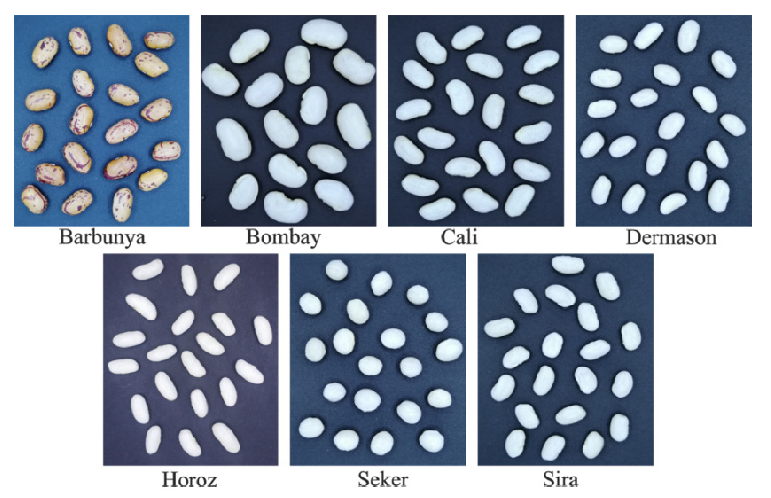

På ROC kurven ser man at Sira og Dermason er lavest, på bilde over ser man at de har geometriske likheter noe som betyr at det er vanskelig å skille de uten mer komplekse features. Det er også verdt å merke seg at det er langt flere samples av dermason og sira i testsettet (som vi så i oppgave 1.1). Det betyr at det at vi ser mange feil mellom at SIRA predikeres som å være DERMASON 51 ganger er relativt ikke så mye ettersom det er mange flere samples av disse. Men vi ser i ROC-kurven at det disse som har dårligst predikering også relativt med de andre klassene


### Task 2.5 Compare SVM vs MLP (Dry Bean)

- Task: Compare the performance of your best SVM and best MLP on the Dry Bean dataset. Fill in the comparison table below.
- Points: 10
- Expectations: Completed comparison table. Recommendation with justification (1 paragraph). Identify which metrics in the table account for the class imbalance you observed in Task 1.1.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Get predictions and probabilities
# (Assuming best_svm and best_mlp are already fitted from Tasks 2.1 and 2.3)
y_pred_svm = best_svm.predict(X_bean_test)
y_proba_svm = best_svm.predict_proba(X_bean_test)

y_pred_mlp = best_mlp.predict(X_bean_test)
y_proba_mlp = best_mlp.predict_proba(X_bean_test)

# 2. Compute Metrics
metrics_data = {
    "Metric": [
        "Test Accuracy",
        "Macro F1-Score",
        "Weighted F1-Score",
        "ROC-AUC (macro)",
    ],
    "SVM": [
        accuracy_score(y_bean_test, y_pred_svm),
        f1_score(y_bean_test, y_pred_svm, average="macro"),
        f1_score(y_bean_test, y_pred_svm, average="weighted"),
        roc_auc_score(y_bean_test, y_proba_svm, multi_class="ovr", average="macro"),
    ],
    "MLP": [
        accuracy_score(y_bean_test, y_pred_mlp),
        f1_score(y_bean_test, y_pred_mlp, average="macro"),
        f1_score(y_bean_test, y_pred_mlp, average="weighted"),
        roc_auc_score(y_bean_test, y_proba_mlp, multi_class="ovr", average="macro"),
    ],
}

# 3. Display Comparison Table
df_compare = pd.DataFrame(metrics_data)
# Round for cleaner display
df_compare["SVM"] = df_compare["SVM"].round(4)
df_compare["MLP"] = df_compare["MLP"].round(4)

print("Comparison of Best Models:")
display(df_compare)

#### Answer

| Metric            | SVM    | MLP    |
| ----------------- | ------ | ------ |
| Test Accuracy     | 0.9273 | 0.9291 |
| Macro F1-Score    | 0.9383 | 0.9405 |
| Weighted F1-Score | 0.9272 | 0.9290 |
| ROC-AUC (macro)   | 0.9941 | 0.9960 |

...


---

## Task 3: Checkerboard Classification

Now you will work with the **Checkerboard Dataset** — a synthetic 2D dataset designed to expose a fundamental limitation of kernel-based methods like SVM.

**Checkerboard Dataset** (Synthetic): A 2D dataset where the plane is divided into a grid of squares with alternating class labels (like a chess board). This dataset challenges kernel-based methods because points that are spatially close can belong to different classes.

First, let's generate and visualize the dataset.


In [ ]:
# Generate Checkerboard dataset
X_checker, y_checker = generate_checkerboard(
    n_samples=2000, grid_size=6, noise=0.01, seed=42
)

# Create DataFrame
df_checker = pd.DataFrame(X_checker, columns=["X", "Y"])
df_checker["Class"] = y_checker

print(f"Shape: {df_checker.shape}")
df_checker.head()

In [ ]:
df_checker["Class"].value_counts()

### Task 3.1 Visualize Checkerboard

- Task: Create a scatter plot of the Checkerboard dataset colored by class label.
- Points: 5
- Expectations: A 2D scatter plot clearly showing the checkerboard pattern. One sentence on what you observe about class separability.


#### Answer


In [ ]:
# Hint: Use plt.scatter with c=y_checker and cmap="bwr" for red/blue classes
plt.scatter(
    X_checker[:, 0], X_checker[:, 1], c=y_checker, cmap="bwr", edgecolors="k", s=50
)
plt.show()
print(
    "Hadde det ikke vært for fargene ville jeg ikke trodd det lå noe data her,\n"
    "en ml-modell som ser på forskjell mellom punkter vil derfor slite her da alt ser ut som støy"
)

In [ ]:
# Train/test split for Checkerboard (80/20)
X_checker_train, X_checker_test, y_checker_train, y_checker_test = train_test_split(
    X_checker, y_checker, test_size=0.2, random_state=42, stratify=y_checker
)

print(f"Training set: {len(X_checker_train)} samples")
print(f"Test set: {len(X_checker_test)} samples")

### Task 3.2 SVM on Checkerboard

- Task: Apply SVM with grid search to the Checkerboard dataset. Use a Pipeline with StandardScaler and SVC (RBF kernel). Search over `C` and `gamma`.
- Points: 10
- Expectations:
  1. Pipeline with `StandardScaler` and `SVC` using `GridSearchCV`
  2. Report best parameters using `print_grid_search_results()`
  3. Evaluation metrics using `print_evaluation_metrics()`
  4. Confusion matrix using `ConfusionMatrixDisplay`
  5. ROC curve with AUC score using `plot_roc_curves()`
  6. Decision boundary using `plot_decision_boundary()`


In [ ]:
# SVM Pipeline: StandardScaler + SVC (RBF kernel)
svm_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svc", SVC(random_state=42, kernel="rbf", probability=True)),
    ]
)

# Hyperparameter grid
svm_param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [0.001, 0.01, 0.1, 1],
}

# Grid search with cross-validation
CV_FOLDS = 5
svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid, cv=CV_FOLDS, scoring="accuracy", n_jobs=-1, refit=True
)
svm_grid.fit(X_checker_train, y_checker_train)

# Print grid search results
print_grid_search_results(svm_grid, "SVM (Checker)")

# Evaluate on test set
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_checker_test)

# Print evaluation metrics
svm_report = print_evaluation_metrics(y_checker_test, y_pred_svm, "SVM (Checker)")

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_checker_test,
    y_pred_svm,
    display_labels=None,  # Ja, den står som None, men labels stemmer
    ax=ax,
    cmap="Blues",
)
ax.set_title("SVM Confusion Matrix — Checker")
plt.tight_layout()
plt.show()

# ROC curve
y_proba_svm = best_svm.predict_proba(X_checker_test)
roc_auc_svm, _ = plot_roc_curves(
    y_checker_test,
    y_proba_svm,
    class_names=None,
    title="SVM ROC Curves — Checker (One-vs-Rest)",
)
plt.show()
print(f"ROC-AUC (macro, OvR): {roc_auc_svm:.4f}")

# Plot decision boundary
# Visualize the decision boundary on both training and validation data
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Decision boundary - Training data (what the model learned from)
plot_decision_boundary(
    best_svm,
    X_checker_train,
    y_checker_train,
    ax=axes[0],
    title=f"Training Data",
)

# Decision boundary - Validation data (unseen during training)
plot_decision_boundary(
    best_svm,
    X_checker_test,
    y_checker_test,
    ax=axes[1],
    title=f"Validation Data",
)


### Task 3.3 MLP on Checkerboard

- Task: Apply MLP with grid search to the Checkerboard dataset. Use a Pipeline with StandardScaler and MLPClassifier (relu activation). Search over `hidden_layer_sizes` and `learning_rate_init`.
- Points: 10
- Expectations:
  1. Pipeline with `StandardScaler` and `MLPClassifier` using `GridSearchCV`
  2. Report best parameters using `print_grid_search_results()`
  3. Evaluation metrics using `print_evaluation_metrics()`
  4. Confusion matrix using `ConfusionMatrixDisplay`
  5. ROC curve with AUC score using `plot_roc_curves()`
  6. Decision boundary using `plot_decision_boundary()`


In [ ]:
# MLP Pipeline: StandardScaler + MLPClassifier (relu activation)
mlp_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "mlp",
            MLPClassifier(activation="relu", random_state=42, max_iter=5000),
        ),
    ]
)

# Hyperparameter grid
mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(100, 50), (100, 100), (100, 100, 50), (100, 100, 100)],
    "mlp__learning_rate_init": [0.001, 0.01, 0.0005],
}

# Grid search with cross-validation
mlp_grid = GridSearchCV(
    mlp_pipe, mlp_param_grid, cv=CV_FOLDS, scoring="accuracy", n_jobs=-1, refit=True
)
mlp_grid.fit(X_checker_train, y_checker_train)

# Print grid search results
print_grid_search_results(mlp_grid, "MLP (Checker)")

# Evaluate on test set
best_mlp = mlp_grid.best_estimator_
y_pred_mlp = best_mlp.predict(X_checker_test)

# Print evaluation metrics
print_evaluation_metrics(y_checker_test, y_pred_mlp, "MLP (Checker)")

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_checker_test,
    y_pred_mlp,
    display_labels=None,
    ax=ax,
    cmap="Greens",
)
ax.set_title("MLP Confusion Matrix — Checker")
plt.tight_layout()
plt.show()

# ROC curve
y_proba_mlp = best_mlp.predict_proba(X_checker_test)
roc_auc_mlp, _ = plot_roc_curves(
    y_checker_test,
    y_proba_mlp,
    class_names=None,
    title="MLP ROC Curves — Checker (One-vs-Rest)",
)
plt.show()
print(f"ROC-AUC (macro, OvR): {roc_auc_mlp:.4f}")

# Plot decision boundary
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Decision boundary - Training data (what the model learned from)
plot_decision_boundary(
    best_mlp,
    X_checker_train,
    y_checker_train,
    ax=axes[0],
    title=f"Training Data",
)

# Decision boundary - Validation data (unseen during training)
plot_decision_boundary(
    best_mlp,
    X_checker_test,
    y_checker_test,
    ax=axes[1],
    title=f"Validation Data",
)

### Task 3.4 Compare Decision Boundaries

Compare the decision boundary plots and accuracy results from Tasks 3.2 and 3.3.

- Task: Describe the decision boundaries and explain why MLP succeeds on the Checkerboard dataset.
- Points: 15
- Expectations:
  1. Describe what you observe about each model's decision boundaries (1-2 sentences each)
  2. Explain how MLP's architecture (hidden layers with ReLU activations) enables it to learn the checkerboard pattern (1 paragraph)
  3. Complete the summary table comparing SVM vs MLP accuracy

**Summary Table:**

| Model      | Checkerboard Test Accuracy |
| ---------- | -------------------------- |
| SVM (best) |                            |
| MLP (best) |                            |
| Difference |                            |


#### Answer 1: Decision Boundary Observations


#### Answer 2: How MLP Learns the Checkerboard Pattern


#### Answer 3: Summary Table
